# Carga de paquetes

In [1]:
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import  DataLoader, ConcatDataset

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import os
import pylab as pl
from IPython import display
import nibabel
from preprocessing import * 

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CARGA DE DATOS

In [2]:
BASE_PATH = os.getcwd() + "\\data"
TRAINING_PATH_AMSTERDAM= BASE_PATH + "\\training\\Amsterdam\\GE3T\\"
TRAINING_PATH_SINGAPORE= BASE_PATH + "\\training\\Singapore\\"
TRAINING_PATH_UTRECHT= BASE_PATH + "\\training\\Utrecht\\"

TEST_PATH_AMSTERDAM= BASE_PATH + "\\test\\Amsterdam\\"
TEST_PATH_SINGAPORE= BASE_PATH + "\\test\\Singapore\\"
TEST_PATH_UTRECHT= BASE_PATH + "\\test\\Utrecht\\"

# DICCIONARIO TRAINING Y TEST

In [3]:
TRAINING_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[],
    "ID":[]
}
createDictionary(TRAINING_PATH_UTRECHT, TRAINING_DICT,"Utrecht")
createDictionary(TRAINING_PATH_SINGAPORE, TRAINING_DICT, "Singapore")
createDictionary(TRAINING_PATH_AMSTERDAM, TRAINING_DICT,"Amsterdam")

In [4]:
TEST_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[],
    "ID":[]
}
createDictionary(TEST_PATH_UTRECHT, TEST_DICT,"Utrecht")
createDictionary(TEST_PATH_SINGAPORE, TEST_DICT,"Singapore")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE1T5"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE3T"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "Philips_VU .PETMR_01"), TEST_DICT,"Amsterdam")

# Crear dataset entrenamiento y test

In [5]:
train,val=divideDataset(TRAINING_DICT,0.8)
print("total training FLAIR images", len(train.__getitem__("pathsFLAIR")))
print("total test FLAIR images", len(val.__getitem__("pathsFLAIR")))

total training FLAIR images 48
total test FLAIR images 12


In [5]:
train,val=getIDs(TRAINING_DICT)
print("total training FLAIR images", len(train.__getitem__("pathsFLAIR")))
print("total test FLAIR images", len(val.__getitem__("pathsFLAIR")))

total training FLAIR images 48
total test FLAIR images 12


In [6]:
print(val)

{'pathsFLAIR': ['c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\11\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\17\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\21\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\25\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\29\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Utrecht\\4\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation\\data\\training\\Singapore\\50\\pre\\FLAIR.nii.gz', 'c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensit

In [6]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True),
])

transform_label=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True, interpolation= transforms.InterpolationMode.NEAREST),
])

In [6]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=True)
print(train_dl.batch_size)

NameError: name 'transform' is not defined

# Preprocesamiento 

-   Cropping and padding
- obtiene region cerebral, se rellenan los huecos que pueda haber, se normaliza con gaussian normalization
- las imágenes finales tienen 2 canales ya que ponen una encima de la otra T1 Y FLAIR
- removing skull


(-0.5, 239.5, 239.5, -0.5)

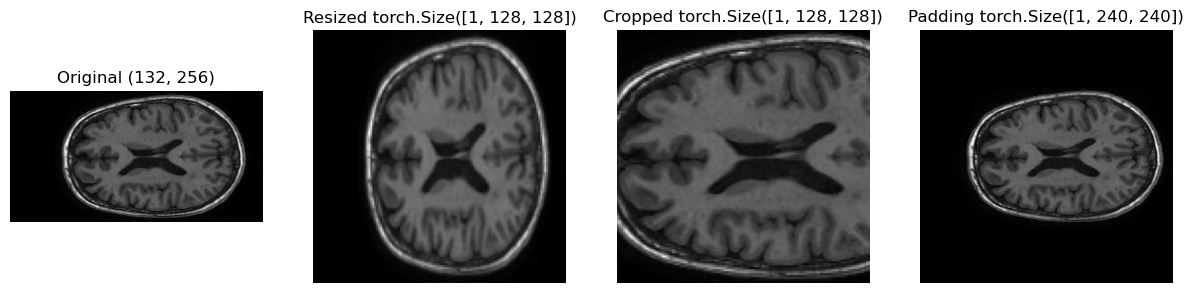

In [48]:
fig,axs = plt.subplots(1, 4, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')

image_res=add_transformation(image_data[:, :, 53],128, True, False)
axs[1].imshow(image_res.squeeze(0), cmap='gray')
axs[1].set_title("Resized %s" %(image_res.shape,))
axs[1].axis('off')

image_crop=add_transformation(image_data[:, :, 53],128, False,False)
axs[2].imshow(image_crop.squeeze(0), cmap='gray')
axs[2].set_title("Cropped %s" %(image_crop.shape,))
axs[2].axis('off')

image_pad=add_transformation(image_data[:, :, 53],240, False,False)
axs[3].imshow(image_pad.squeeze(0), cmap='gray')
axs[3].set_title("Padding %s" %(image_pad.shape,))
axs[3].axis('off')


(-0.5, 239.5, 239.5, -0.5)

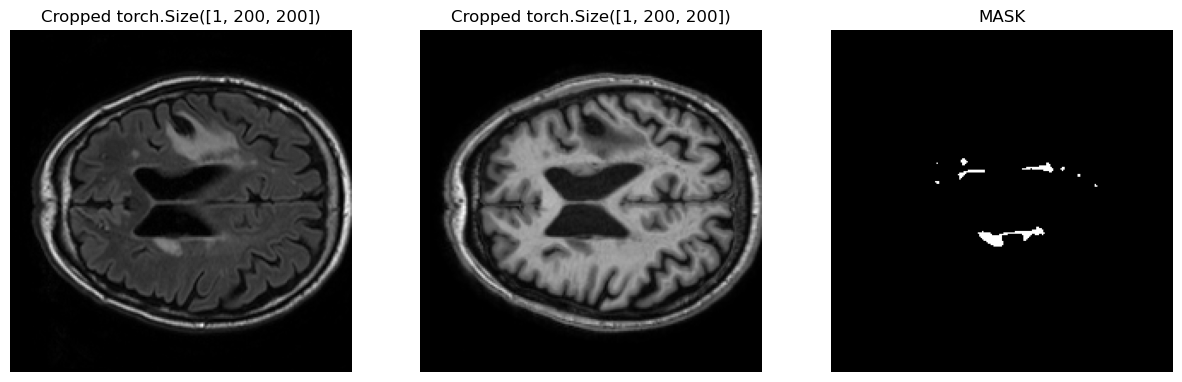

In [49]:
fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_UTRECHT, "19","pre","FLAIR.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_crop=add_transformation(image_data[:, :, 31],200, False,False)
axs[0].imshow(image_crop.squeeze(0), cmap='gray')
axs[0].set_title("Cropped %s" %(image_crop.shape,))
axs[0].axis('off')

flair= os.path.join(TRAINING_PATH_UTRECHT, "19","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_crop=add_transformation(image_data[:, :, 31],200, False,False)
axs[1].imshow(image_crop.squeeze(0), cmap='gray')
axs[1].set_title("Cropped %s" %(image_crop.shape,))
axs[1].axis('off')

mask= os.path.join(TRAINING_PATH_UTRECHT, "19", "wmh.nii.gz")
img = nib.load(mask)
image_data = img.get_fdata() 
merged_image= np.array(image_data)
merged_image[merged_image==1]=255
merged_image[merged_image==2]=0
merged_image[merged_image==3]=255
image_data= merged_image


axs[2].imshow(image_data[:, :,31], cmap='gray')
axs[2].set_title("MASK")
axs[2].axis('off')

# Skull stripping

# Concatenar imágenes

(-0.5, 255.5, 131.5, -0.5)

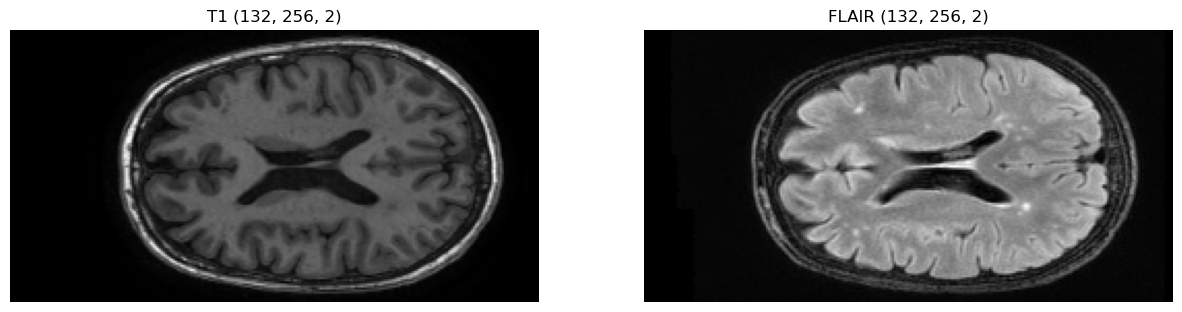

In [50]:
fig,axs = plt.subplots(1, 2, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","FLAIR.nii.gz")
t1=os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")

fl = nibabel.load(flair)
fl_data = fl.get_fdata()[:,:,53] 
t=nibabel.load(t1)
t_data=t.get_fdata()[:,:,53] 
image_orig=numpy.concatenate((t_data[...,np.newaxis],fl_data[...,np.newaxis]), axis=2)
axs[0].imshow(image_orig[...,0], cmap='gray')
axs[0].set_title("T1 %s" %(image_orig.shape,))
axs[0].axis('off')

axs[1].imshow(image_orig[...,1], cmap='gray')
axs[1].set_title("FLAIR %s" %(image_orig.shape,))
axs[1].axis('off')

## Brain Filling &  Normalización

(-0.5, 255.5, 131.5, -0.5)

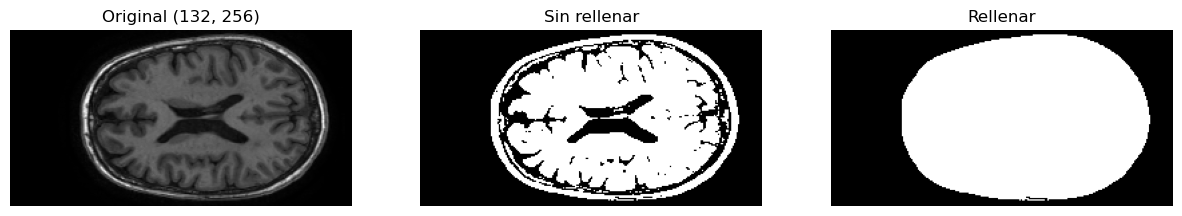

In [51]:
fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')


mask= brainMask(image_orig)
axs[1].imshow(mask, cmap='gray')
axs[1].set_title("Sin rellenar")
axs[1].axis('off')


mask= brainfilling(mask)
axs[2].imshow(mask, cmap='gray')
axs[2].set_title("Rellenar")
axs[2].axis('off')


(-0.5, 255.5, 131.5, -0.5)

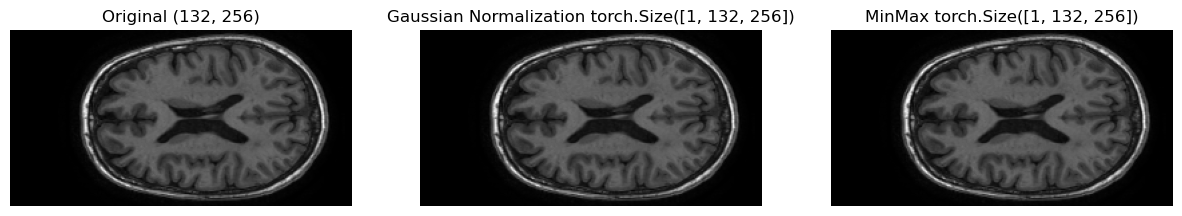

In [52]:

fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')
mask_tensor= transforms.ToTensor()(mask)
image_res=gaussian_normalizationFILL(transforms.ToTensor()(image_data[:, :, 53]), mask_tensor)
axs[1].imshow(image_res.squeeze(0), cmap='gray')
axs[1].set_title("Gaussian Normalization %s" %(image_res.shape,))
axs[1].axis('off')

image_crop=minmax_normalizationFILL(transforms.ToTensor()(image_data[:, :, 53]), mask_tensor)
axs[2].imshow(image_crop.squeeze(0), cmap='gray')
axs[2].set_title("MinMax %s" %(image_crop.shape,))
axs[2].axis('off')

# MÉTODOS ENTRENAMIENTO

In [6]:
from unet import UNet 
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = UNet(in_channels=1,out_channels=1, init_features=32)
model=model.to(device)

In [7]:
def traintestpipeline(epochs: int, optim: Adam, criterion: DiceLoss, min_loss: int, name: str):
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))
    pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
    for epoch in pbar:
        
        train_loss = 0 
        val_loss = 0  
        
        model.train()                                                  
        for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        

            input_img= input_img.to(device).float()
            target = target.to(device).float()
            
            
            output = model(input_img)
            loss = criterion(output, target)
            loss.backward()                                            
            optim.step()                                               
            optim.zero_grad()     
            
            train_loss += loss.item()    
                                                        
        model.eval()   
        with torch.no_grad():                                          
            for input_img, target in val_dl: 
                input_img = input_img.to(device).float()
                target = target.to(device)
                
                output = model(input_img)                                   
                loss = criterion(output, target)   
                val_loss += loss.item()  
        
        # RESULTATS
        train_loss /= len(train_dl)
        t_loss[epoch-1] = train_loss
        
        val_loss /= len(val_dl)   
        v_loss[epoch-1] = val_loss
        if(v_loss[epoch-1]<min_loss):
            min_loss=v_loss[epoch-1]
            torch.save(model.state_dict(), name)  
        # VISUALITZACIO DINAMICA
        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

- dice coefficient
- hausdorf distance
- precision
- accuracy
- Intersection over Union(IOU)

- Average volume difference (in percentage)
- Sensitivity for individual lesions (recall)
-  F1-score for individual lesions

https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f 

In [8]:
def precision_score(pred_mask,groundtruth_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = torch.sum(pred_mask)
    precision = torch.mean(intersect/total_pixel_pred)
    return precision

def recall_score(pred_mask, groundtruth_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = torch.sum(groundtruth_mask)
    if(torch.all(total_pixel_truth==0)):
        recall= torch.tensor(0.0)
    else:    
        recall = torch.mean(intersect/total_pixel_truth)
    return recall

def accuracy(pred_mask,groundtruth_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    xor = torch.sum(groundtruth_mask==pred_mask)
    acc = torch.mean(xor/(union + xor - intersect))
    return acc

def iou_score(pred_mask, groundtruth_mask):
    intersect = torch.sum(pred_mask*groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    iou = torch.mean(intersect/union)
    return iou

https://github.com/Project-MONAI/MONAI/discussions/2179 problema con HausdorffDistance

In [9]:
import torch
from monai.metrics import DiceMetric, HausdorffDistanceMetric, get_mask_edges, get_surface_distance

def calculate_metrics(model, test_dl, device):
    model.eval()
    total_dice = 0
    total_hd = 0
    total_pre = 0
    total_rec = 0
    total_acc = 0
    total_iou=0
    total = len(test_dl)
    

    dice_metric = DiceMetric(include_background=True, reduction="mean")
    hd_metric = HausdorffDistanceMetric(include_background=True, reduction="mean")

    with torch.no_grad():
        for input_img, target in test_dl:
            input_img = input_img.to(device).float()
            target = target.to(device).float()

            output = model(input_img)

            dice = dice_metric(output, target)
            dice = np.nan_to_num(dice.cpu().numpy())
            total_dice += dice.mean()

            if(torch.all(target==0) or torch.all(output==0)):
                hd= torch.tensor(1.0)     
            else:    
                hd = hd_metric(output, target)
                hd = np.nan_to_num(hd.cpu().numpy())
            total_hd += hd.mean()
        
           
            # Compute confusion matrix
            #confusion_matrix = get_confusion_matrix(pred_binary, target)
            pre = precision_score(output, target)
            total_pre+=pre

            rec = recall_score(output, target)
            total_rec+=rec

            acc = accuracy(output, target)
            total_acc+=acc

            iou = iou_score(output, target)
            total_iou+=iou
            


    total_dice /= total
    total_hd /= total
    total_pre /=total
    total_rec /=total
    total_acc /=total
    total_iou /= total
    print("Dice coefficient:", total_dice)
    print("IOU:", total_iou)
    print("Hausdorff Distance:", total_hd)
    print("Precision:", total_pre)
    print("Recall:", total_rec)
    print("Accuracy:", total_acc)


In [10]:
def assignPretrainedModel(device,name:str):
    mmodel =  model.to(device)
    mmodel.load_state_dict(torch.load(name))
    mmodel.eval();
    return mmodel

## Modelo con todo el conjunto de imágenes

In [58]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2934
646


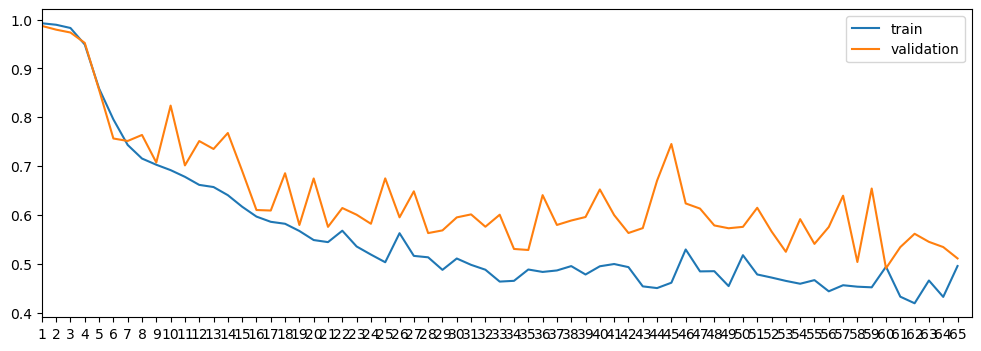

Epoch:65 Training Loss:0.49536617658177784 Validation Loss:0.5109622383924023: 100%|██████████| 65/65 [31:32<00:00, 29.12s/it]


In [59]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/NODeletion128FLAIR.pt")

In [60]:
model=assignPretrainedModel(device,"./Modelos3DUNET/NODeletion128FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.07740579530185174
IOU: tensor(0.1960, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.3107, device='cuda:0')
Recall: tensor(0.2782, device='cuda:0')
Accuracy: tensor(0.3107, device='cuda:0')


In [61]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2934
646


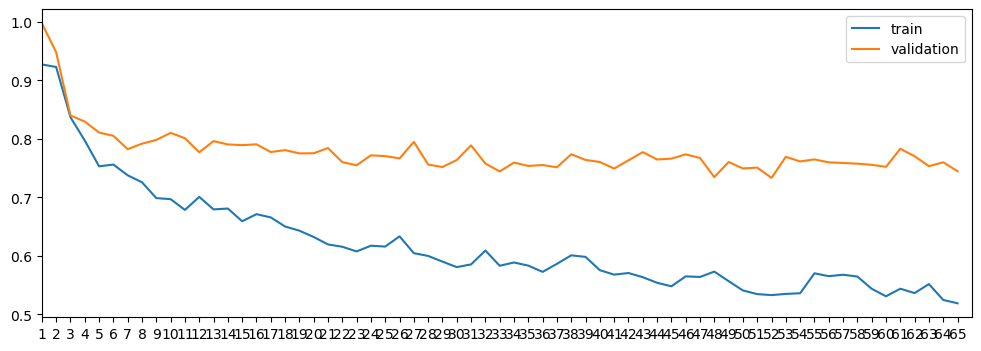

Epoch:65 Training Loss:0.5189562730248405 Validation Loss:0.7448052231558925: 100%|██████████| 65/65 [31:57<00:00, 29.51s/it]


In [62]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/NODeletion128T1.pt")

In [63]:
model=assignPretrainedModel(device,"./Modelos3DUNET/NODeletion128T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.040021959756968616
IOU: tensor(0.0888, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.1570, device='cuda:0')
Recall: tensor(0.1516, device='cuda:0')
Accuracy: tensor(0.5441, device='cuda:0')


# Modelo sin el 20% de los slices:

In [64]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


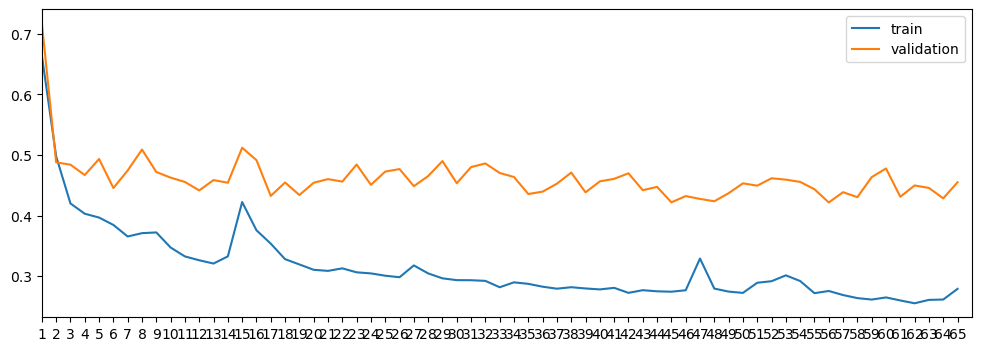

Epoch:65 Training Loss:0.27919727080639956 Validation Loss:0.45506661065186926: 100%|██████████| 65/65 [25:23<00:00, 23.44s/it]


In [65]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Deletion128FLAIR.pt")

In [66]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Deletion128FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.16308806194666478
IOU: tensor(0.2560, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.4202, device='cuda:0')
Recall: tensor(0.3669, device='cuda:0')
Accuracy: tensor(0.7963, device='cuda:0')


In [67]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


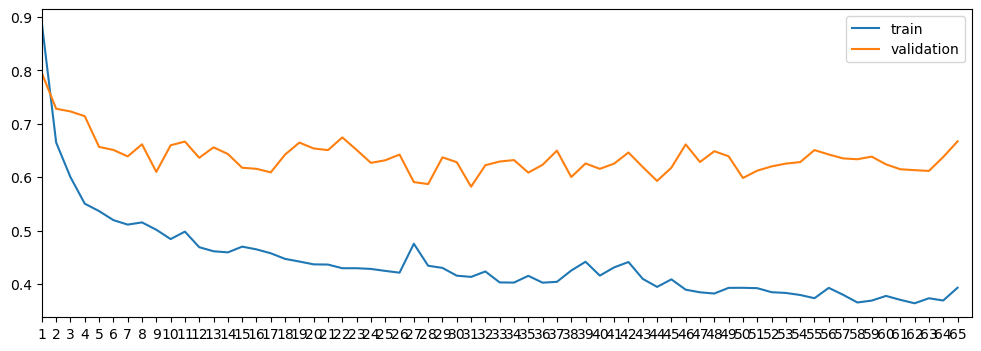

Epoch:65 Training Loss:0.3928702936600089 Validation Loss:0.6669611046281557: 100%|██████████| 65/65 [25:22<00:00, 23.43s/it] 


In [68]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Deletion128T1.pt")

In [69]:
model=assignPretrainedModel(device,"./Modelos3DUNET/Deletion128T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.07035287117346582
IOU: tensor(0.1570, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2793, device='cuda:0')
Recall: tensor(0.2476, device='cuda:0')
Accuracy: tensor(0.6822, device='cuda:0')


# Modelos con Resize 

Se asume que sin los slices el modelo es mejor(Pendiente de los resultados)

## 128x128 

In [70]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


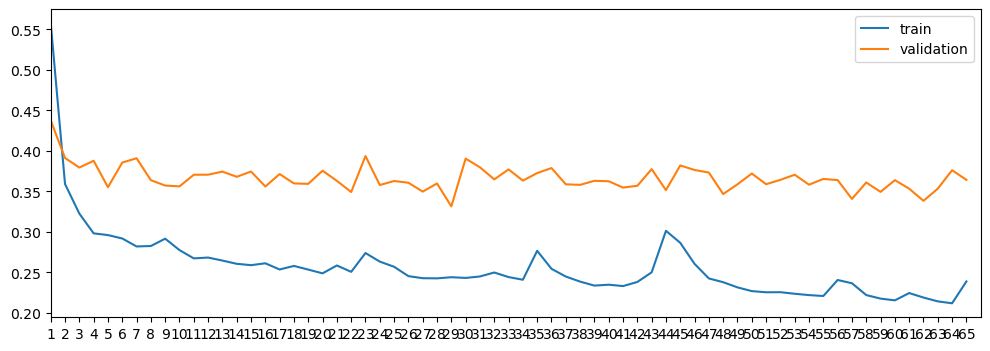

Epoch:65 Training Loss:0.23868615256699535 Validation Loss:0.3641761832421719: 100%|██████████| 65/65 [25:22<00:00, 23.43s/it]


In [71]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize128FLAIR.pt")

In [72]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize128FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.20062913762552564
IOU: tensor(0.2956, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.4202, device='cuda:0')
Recall: tensor(0.4276, device='cuda:0')
Accuracy: tensor(0.8142, device='cuda:0')


In [73]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


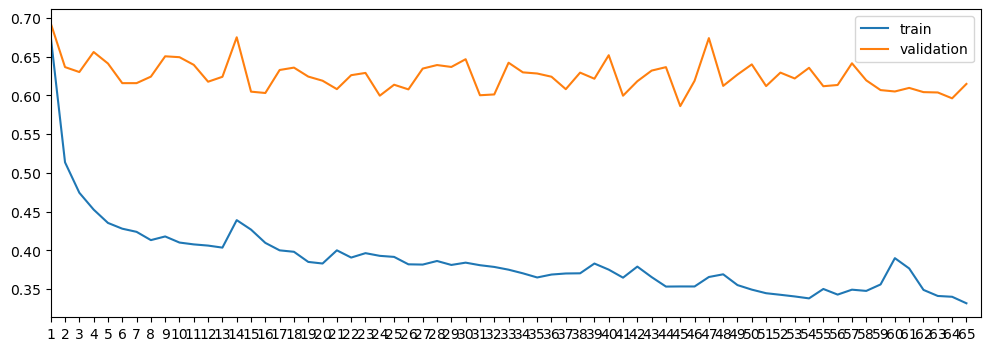

Epoch:65 Training Loss:0.3315331227937885 Validation Loss:0.6149533975291193: 100%|██████████| 65/65 [25:27<00:00, 23.50s/it] 


In [74]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize128T1.pt")

In [75]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize128T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.09125030923536734
IOU: tensor(0.1661, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2729, device='cuda:0')
Recall: tensor(0.2648, device='cuda:0')
Accuracy: tensor(0.8492, device='cuda:0')


## 256 x 256

In [11]:
transform, transform_label=transform_setter(256,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


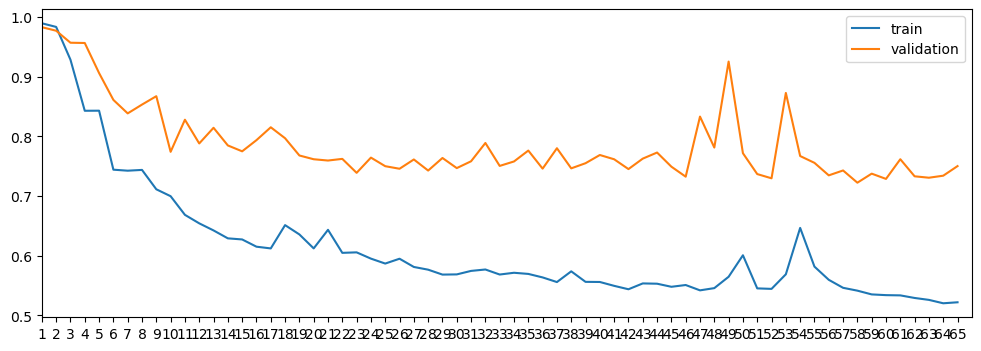

Epoch:65 Training Loss:0.521829226353854 Validation Loss:0.7502881966082174: 100%|██████████| 65/65 [1:28:10<00:00, 81.39s/it]


In [13]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize256FLAIR.pt")

In [14]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize256FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.11010502938634568
IOU: tensor(0.1228, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2360, device='cuda:0')
Recall: tensor(0.3239, device='cuda:0')
Accuracy: tensor(0.0823, device='cuda:0')


In [12]:
transform, transform_label=transform_setter(256,True)

In [13]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


In [14]:
torch.cuda.empty_cache()


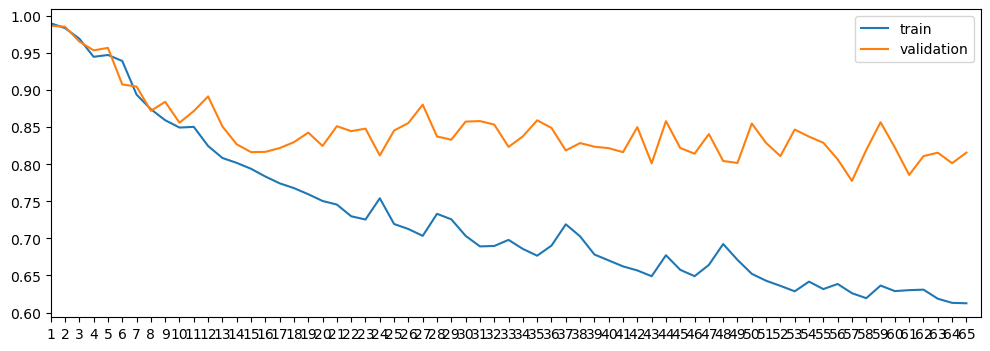

Epoch:65 Training Loss:0.6124501564837799 Validation Loss:0.8157876502413118: 100%|██████████| 65/65 [1:28:12<00:00, 81.42s/it]


In [15]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize256T1.pt")

In [16]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize256T1.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.04208037649529471
IOU: tensor(0.0810, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.1765, device='cuda:0')
Recall: tensor(0.1163, device='cuda:0')
Accuracy: tensor(0.2848, device='cuda:0')


## 384 x 384

In [11]:
transform, transform_label=transform_setter(384,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,7,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


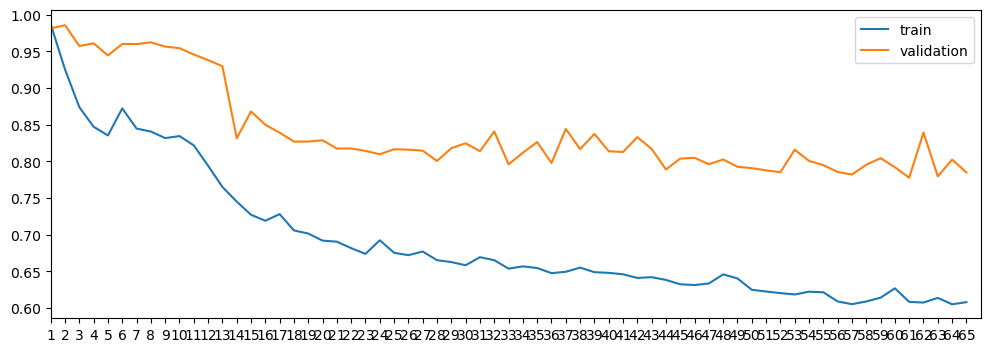

Epoch:65 Training Loss:0.6078835335130188 Validation Loss:0.7847929960223489: 100%|██████████| 65/65 [3:18:00<00:00, 182.77s/it]


In [12]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize384FLAIR.pt")

In [13]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize384FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.1021411144058986
IOU: tensor(0.1312, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2579, device='cuda:0')
Recall: tensor(0.2932, device='cuda:0')
Accuracy: tensor(0.0945, device='cuda:0')


In [14]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,7,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


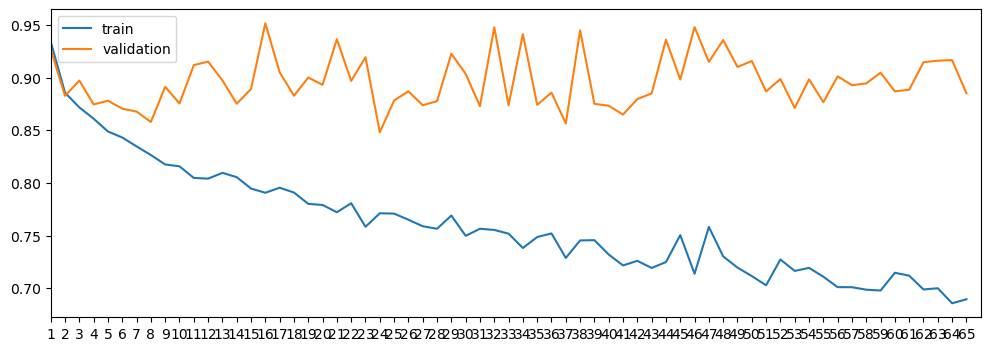

Epoch:65 Training Loss:0.6895356822278993 Validation Loss:0.8851277887104192: 100%|██████████| 65/65 [3:18:30<00:00, 183.24s/it]


In [15]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize384T1.pt")

In [16]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize384T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.05155804085454867
IOU: tensor(0.0695, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.1505, device='cuda:0')
Recall: tensor(0.1032, device='cuda:0')
Accuracy: tensor(0.3938, device='cuda:0')


## 200 x 200

In [53]:
model = UNet(in_channels=1,out_channels=1, init_features=32, is200pad=True,is200crop=False)
model=model.to(device)

In [55]:
transform, transform_label=transform_setter(200,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


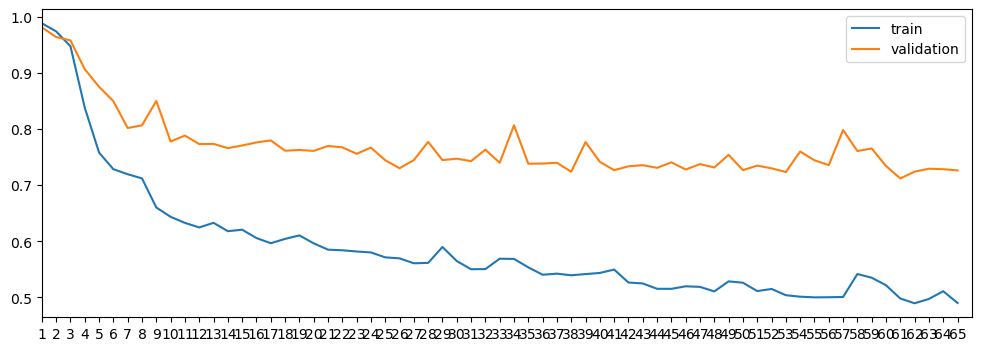

Epoch:65 Training Loss:0.490228610269485 Validation Loss:0.7264737258780394: 100%|██████████| 65/65 [57:38<00:00, 53.20s/it] 


In [56]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200FLAIRpad.pt")

In [57]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize200FLAIRpad.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.1063150693883041
IOU: tensor(0.1350, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2351, device='cuda:0')
Recall: tensor(0.2703, device='cuda:0')
Accuracy: tensor(0.0890, device='cuda:0')


In [36]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


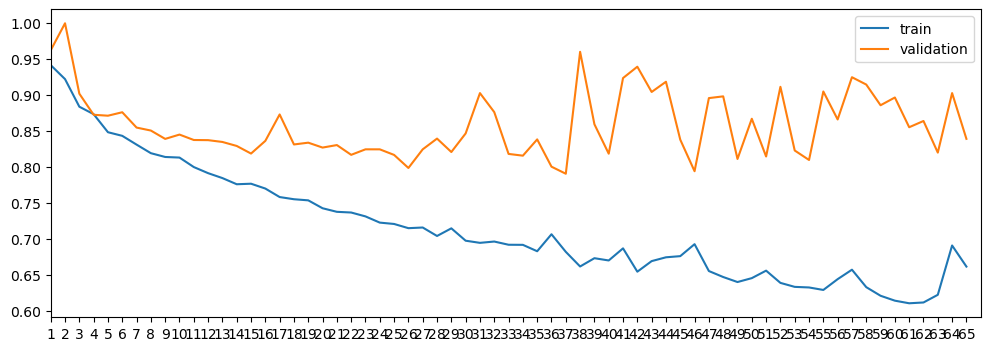

Epoch:65 Training Loss:0.6619031471590842 Validation Loss:0.8393915439725385: 100%|██████████| 65/65 [59:24<00:00, 54.84s/it]


In [37]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200T1pad.pt")

In [38]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize200T1pad.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.043380097247657096
IOU: tensor(0.0732, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.1442, device='cuda:0')
Recall: tensor(0.1302, device='cuda:0')
Accuracy: tensor(0.4629, device='cuda:0')


In [39]:
model = UNet(in_channels=1,out_channels=1, init_features=32, is200pad=False,is200crop=True)
model=model.to(device)

In [40]:
transform, transform_label=transform_setter(200,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


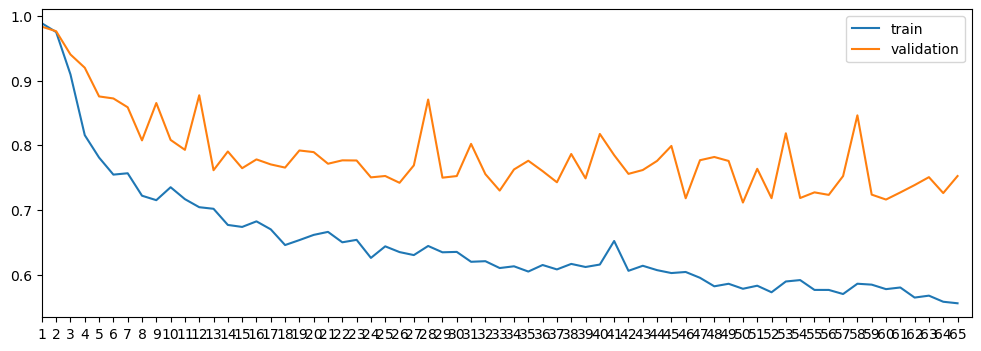

Epoch:65 Training Loss:0.5557551899263936 Validation Loss:0.7524185538142478: 100%|██████████| 65/65 [1:04:29<00:00, 59.53s/it]


In [41]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200FLAIRcrop.pt")

In [42]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize200FLAIRcrop.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.07373305033926092
IOU: tensor(0.1294, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2705, device='cuda:0')
Recall: tensor(0.2376, device='cuda:0')
Accuracy: tensor(0.0618, device='cuda:0')


In [43]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


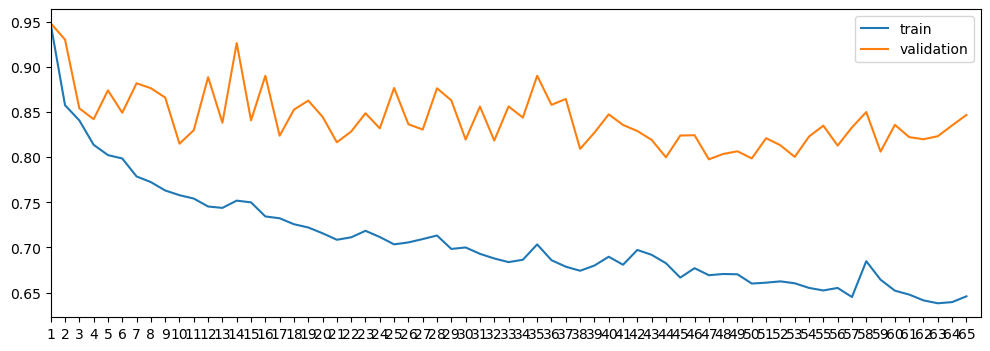

Epoch:65 Training Loss:0.6457715630531311 Validation Loss:0.846815481841137: 100%|██████████| 65/65 [1:04:24<00:00, 59.45s/it] 


In [44]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200T1crop.pt")

In [45]:
model=assignPretrainedModel(device,"./Modelos3DUNET/RESIZE/Resize200T1crop.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.02451979559172239
IOU: tensor(0.0821, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.1525, device='cuda:0')
Recall: tensor(0.1422, device='cuda:0')
Accuracy: tensor(0.3340, device='cuda:0')


# Modelos con Crop/Pad

## 200 x 200

Seg´´un si va mejor crop o pad dentro de la unet seleccionar modelo correspondiente y entrenar

In [11]:
model = UNet(in_channels=1,out_channels=1, init_features=32, is200pad=True,is200crop=False)
model=model.to(device)

In [12]:
transform, transform_label=transform_setter(200,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


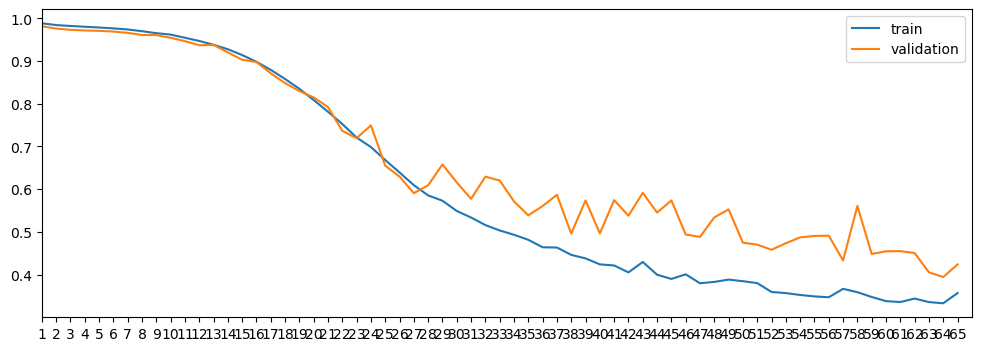

Epoch:65 Training Loss:0.356797121801684 Validation Loss:0.4239862683547691: 100%|██████████| 65/65 [58:24<00:00, 53.92s/it]  


In [13]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop200FLAIR.pt")

In [14]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop200FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.19305790315970386
IOU: tensor(0.3189, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.4872, device='cuda:0')
Recall: tensor(0.3992, device='cuda:0')
Accuracy: tensor(0.2431, device='cuda:0')


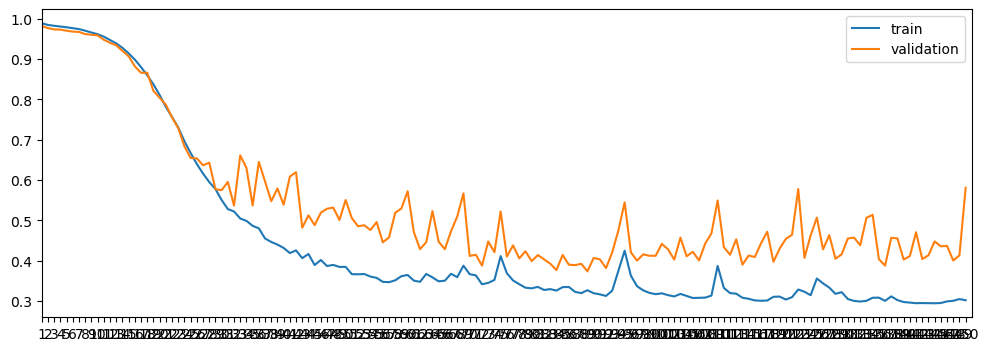

Epoch:150 Training Loss:0.30175396742359284 Validation Loss:0.580506386354822: 100%|██████████| 150/150 [2:18:16<00:00, 55.31s/it]


In [13]:
epochs = 150
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop200FLAIR150.pt")

In [14]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop200FLAIR150.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.2281009573759021
IOU: tensor(0.3269, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.4711, device='cuda:0')
Recall: tensor(0.4322, device='cuda:0')
Accuracy: tensor(0.2755, device='cuda:0')


In [15]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


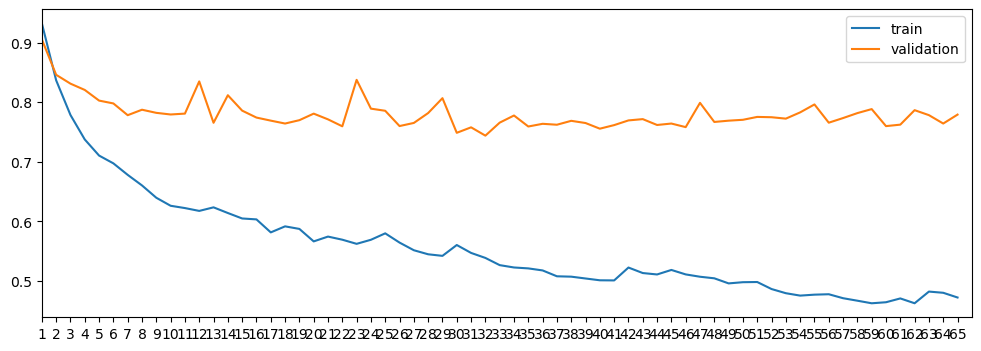

Epoch:65 Training Loss:0.47228751028737714 Validation Loss:0.7792844961715012: 100%|██████████| 65/65 [58:19<00:00, 53.84s/it]


In [16]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop200T1.pt")

In [17]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop200T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.025011172134882624
IOU: tensor(0.1046, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2068, device='cuda:0')
Recall: tensor(0.1419, device='cuda:0')
Accuracy: tensor(0.0259, device='cuda:0')


## 240 x240

In [15]:
model = UNet(in_channels=1,out_channels=1, init_features=32)
model=model.to(device)

In [16]:
transform, transform_label=transform_setter(240,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


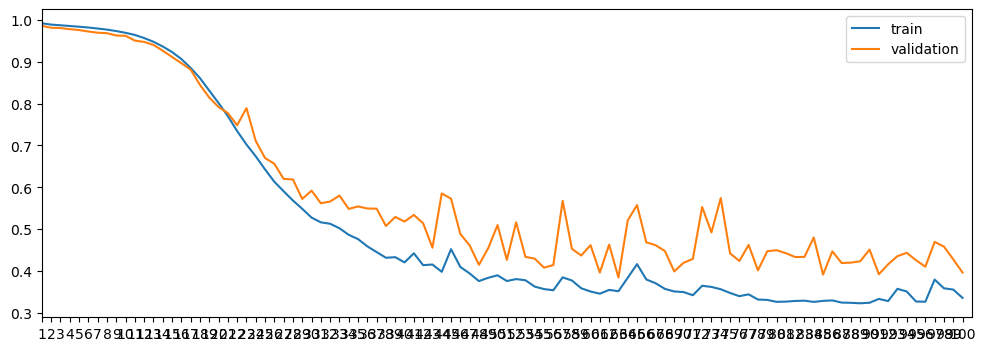

Epoch:100 Training Loss:0.33608962951167937 Validation Loss:0.3966346077651867: 100%|██████████| 100/100 [2:09:10<00:00, 77.50s/it]


In [17]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop240FLAIR.pt")

In [18]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop240FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.17758836261560454
IOU: tensor(0.3371, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.5163, device='cuda:0')
Recall: tensor(0.4119, device='cuda:0')
Accuracy: tensor(0.2312, device='cuda:0')


In [19]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


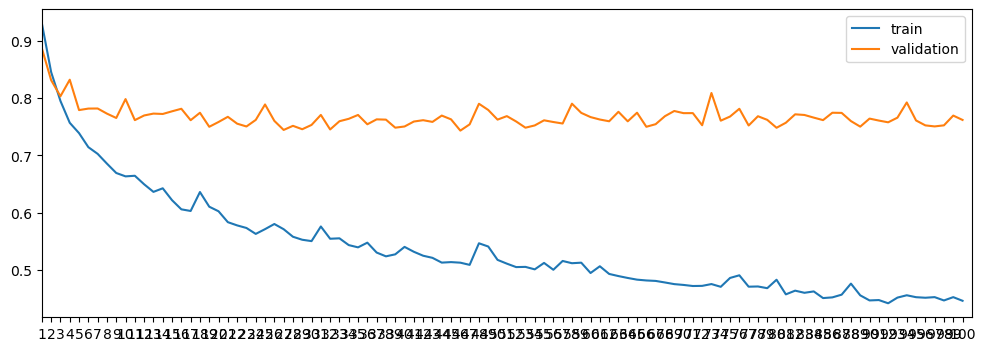

Epoch:100 Training Loss:0.4465693700698114 Validation Loss:0.7617159340779408: 100%|██████████| 100/100 [2:09:09<00:00, 77.50s/it]


In [20]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop240T1.pt")

In [21]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop240T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.0035768401468215557
IOU: tensor(0.1136, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2277, device='cuda:0')
Recall: tensor(0.1491, device='cuda:0')
Accuracy: tensor(0.0431, device='cuda:0')


## 256 x 256

In [22]:
transform, transform_label=transform_setter(256,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


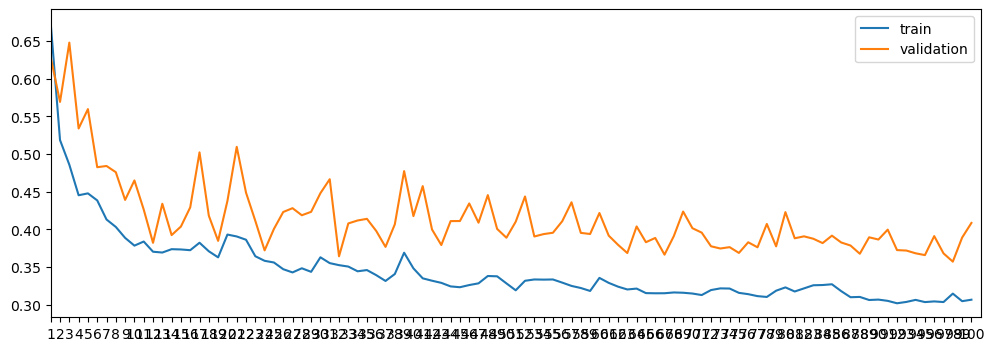

Epoch:100 Training Loss:0.306595306627212 Validation Loss:0.4084804055300735: 100%|██████████| 100/100 [2:25:22<00:00, 87.23s/it]


In [23]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop256FLAIR.pt")

In [24]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2074568337408556
IOU: tensor(0.3480, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.5175, device='cuda:0')
Recall: tensor(0.4505, device='cuda:0')
Accuracy: tensor(0.4506, device='cuda:0')


In [25]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


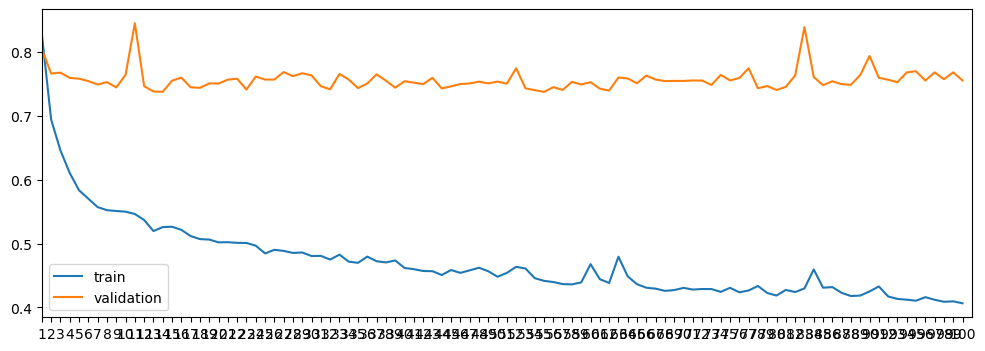

Epoch:100 Training Loss:0.40637190341949464 Validation Loss:0.7556499802766355: 100%|██████████| 100/100 [2:21:27<00:00, 84.88s/it]


In [26]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop256T1.pt")

In [64]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.0
IOU: tensor(0.0887, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.1813, device='cuda:0')
Recall: tensor(0.1354, device='cuda:0')
Accuracy: tensor(0.7025, device='cuda:0')


## 384 x 384

In [11]:
transform, transform_label=transform_setter(384,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,7,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


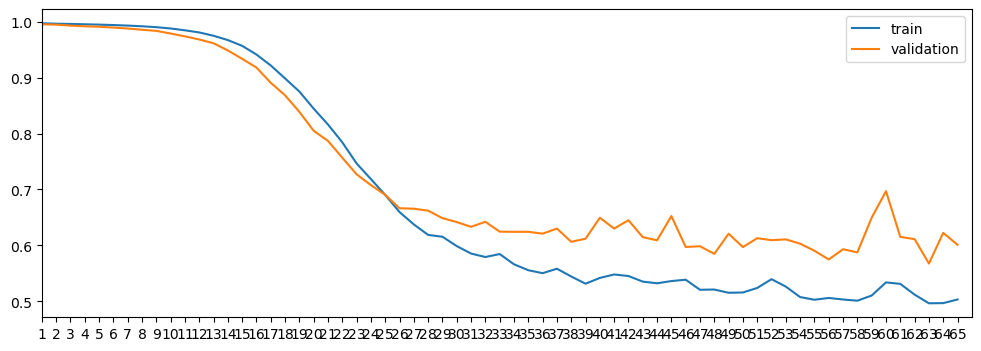

Epoch:65 Training Loss:0.5035260894147291 Validation Loss:0.6012212911656315: 100%|██████████| 65/65 [3:20:23<00:00, 184.98s/it] 


In [12]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop384FLAIR.pt")

In [13]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop384FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.22297755417944007
IOU: tensor(0.3211, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.5140, device='cuda:0')
Recall: tensor(0.4470, device='cuda:0')
Accuracy: tensor(0.2592, device='cuda:0')


In [14]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,7,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


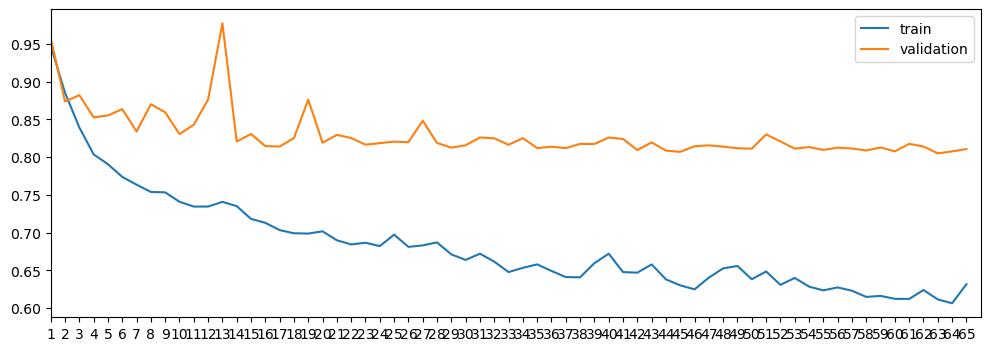

Epoch:65 Training Loss:0.6316726184323475 Validation Loss:0.8107886747356172: 100%|██████████| 65/65 [3:23:10<00:00, 187.55s/it]


In [15]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop384T1.pt")

In [16]:
model=assignPretrainedModel(device,"./Modelos3DUNET/CROP/Crop384T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.06308339490052803
IOU: tensor(0.1174, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(0.2365, device='cuda:0')
Recall: tensor(0.1607, device='cuda:0')
Accuracy: tensor(0.5232, device='cuda:0')


# Modelos con Normalizacion

Se asume un tamaño con Reize de 256x256(pendiente resultados)
Se asume un tamaño con Crop and Pad de 200x200(pendiente resultados)

## Gaussian Normalization Resize 256x256

- 1: Gaussian normalization
- 3: Gaussian Normalization cerebro
- 5: gaussian normalization del cerebro completo

In [32]:
transform, transform_label=transform_normalization(256,True,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


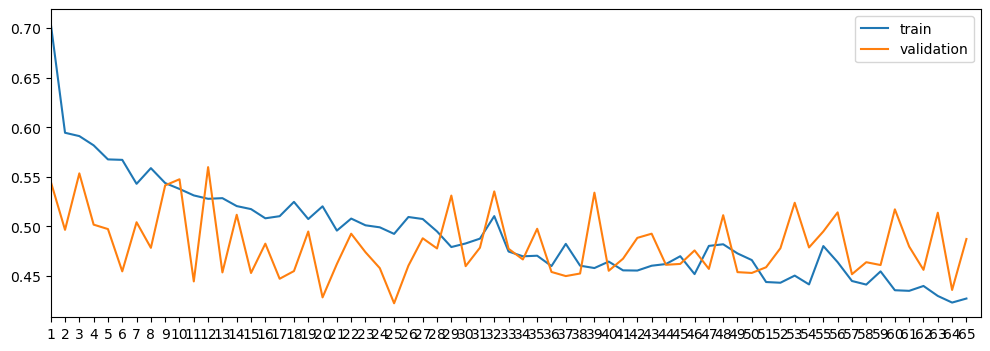

Epoch:65 Training Loss:0.4272668588546015 Validation Loss:0.4873324878069564: 100%|██████████| 65/65 [1:30:44<00:00, 83.76s/it]


In [66]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR.pt")

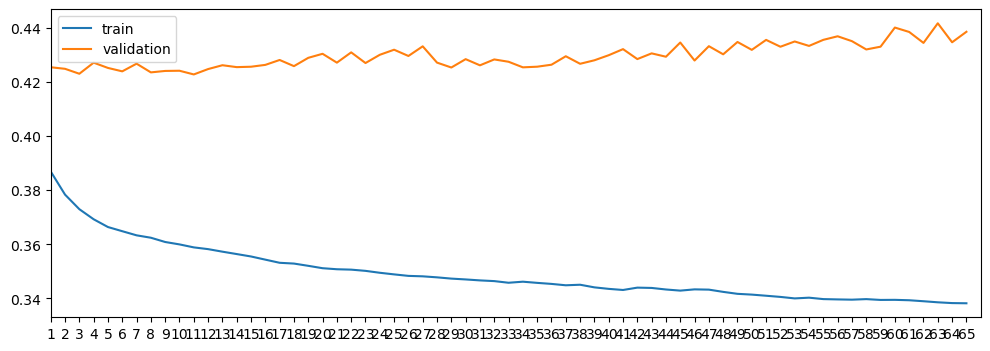

Epoch:65 Training Loss:0.3382336228124557 Validation Loss:0.4384429684066739: 100%|██████████| 65/65 [1:32:00<00:00, 84.94s/it]  


In [33]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256FLAIRlr4.pt")

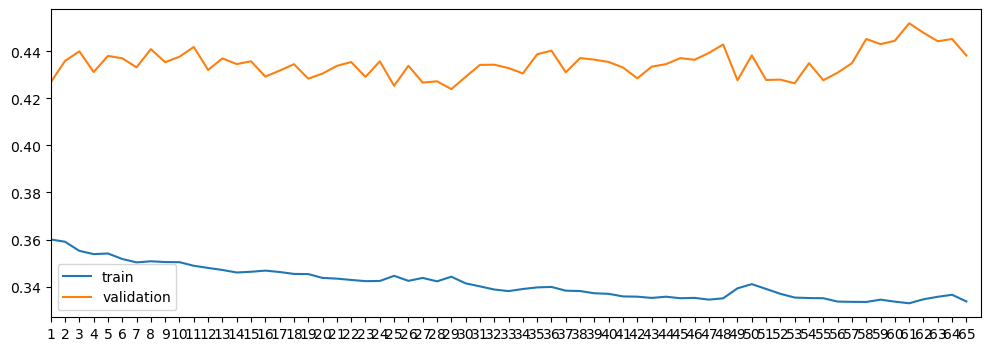

Epoch:65 Training Loss:0.3336930840246139 Validation Loss:0.4382088737084471: 100%|██████████| 65/65 [1:32:08<00:00, 85.06s/it]


In [35]:
epochs = 65
optim = Adam(model.parameters(), lr=0.0002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR0002.pt")

In [67]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.0
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.5413, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [34]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256FLAIRlr4.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2421939703721651
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.4226, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [36]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR0002.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.2543888839353856
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.4431, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [12]:
transform, transform_label=transform_normalization(256,True,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


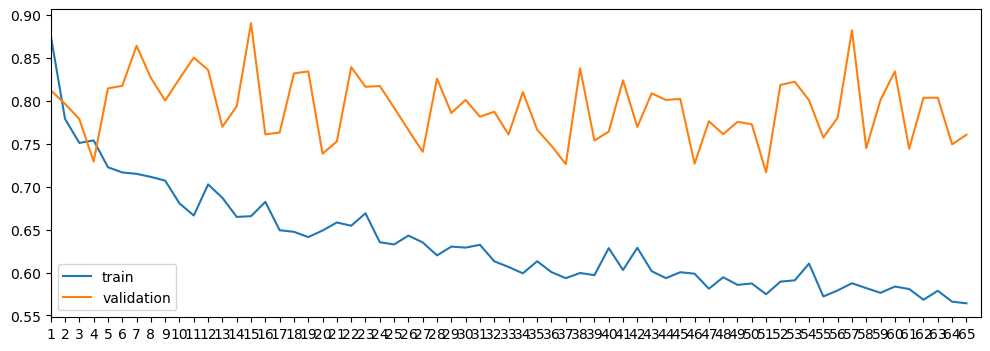

Epoch:65 Training Loss:0.5642118923125728 Validation Loss:0.7602484778189346: 100%|██████████| 65/65 [1:30:49<00:00, 83.84s/it]


In [69]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256T1.pt")

In [70]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.0
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


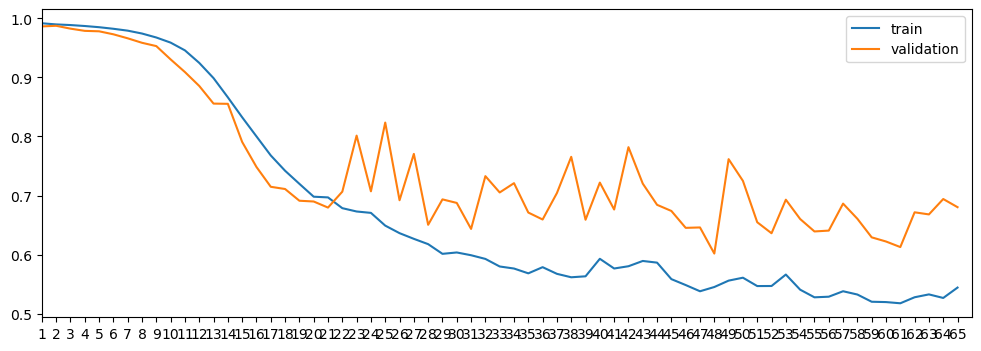

Epoch:65 Training Loss:0.5441224467369818 Validation Loss:0.6802565043309204: 100%|██████████| 65/65 [1:34:31<00:00, 87.25s/it]


In [13]:
epochs = 65
optim = Adam(model.parameters(), lr=0.0002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256T10002.pt")

In [14]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GN256T10002.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.1432589104029926
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [28]:
transform, transform_label=transform_normalization(256,True,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


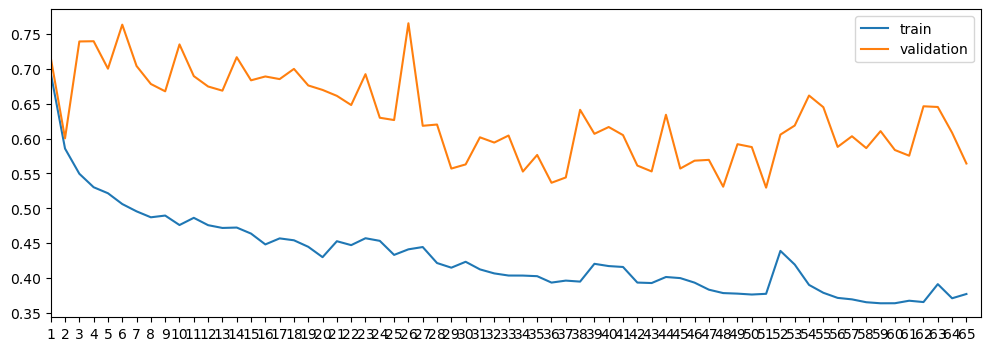

Epoch:65 Training Loss:0.37719703220552014 Validation Loss:0.5641914617834536: 100%|██████████| 65/65 [1:39:33<00:00, 91.90s/it]


In [16]:
epochs = 65
optim = Adam(model.parameters(), lr=0.0002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNMask256FLAIR.pt")

In [17]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNMask256FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:127: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


Dice coefficient: 0.15502504040012258
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.3832, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


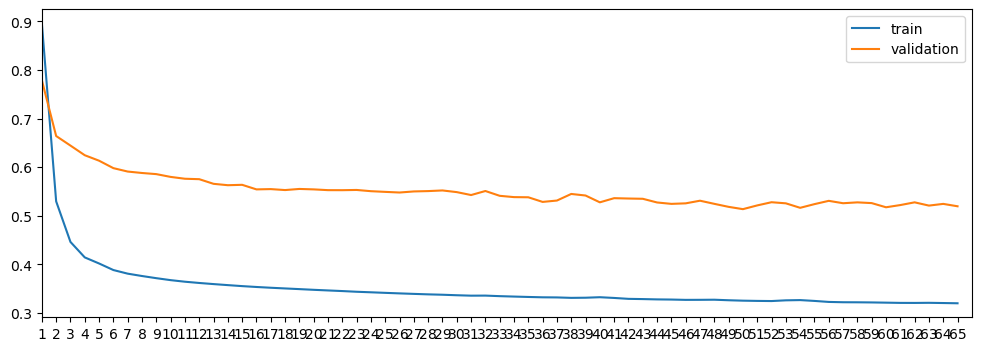

Epoch:65 Training Loss:0.3198143866754347 Validation Loss:0.5193960256768566: 100%|██████████| 65/65 [1:37:11<00:00, 89.72s/it]


In [29]:
epochs = 65
optim = Adam(model.parameters(), lr=0.00002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNMask256FLAIR02.pt")

In [30]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNMask256FLAIR02.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2096182477660477
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.3899, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [31]:
transform, transform_label=transform_normalization(256,True,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


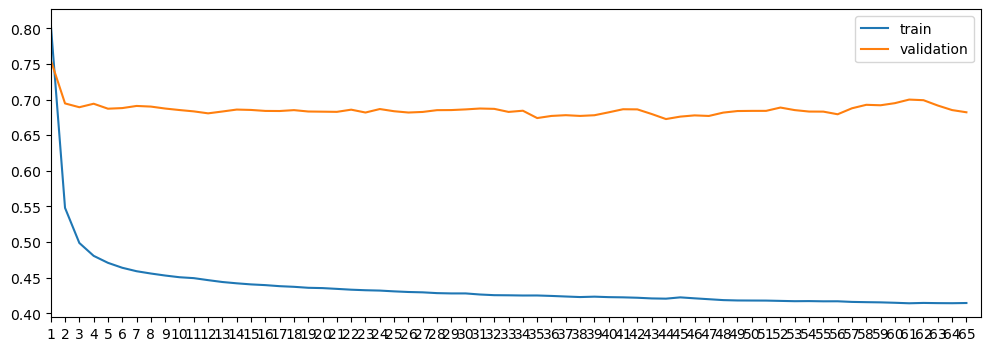

Epoch:65 Training Loss:0.4144139209101277 Validation Loss:0.6821408153823545: 100%|██████████| 65/65 [1:37:07<00:00, 89.65s/it]


In [32]:
epochs = 65
optim = Adam(model.parameters(), lr=0.00002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNMask256T1.pt")

In [34]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNMask256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.10643091979773568
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [35]:
transform, transform_label=transform_normalization(256,True,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


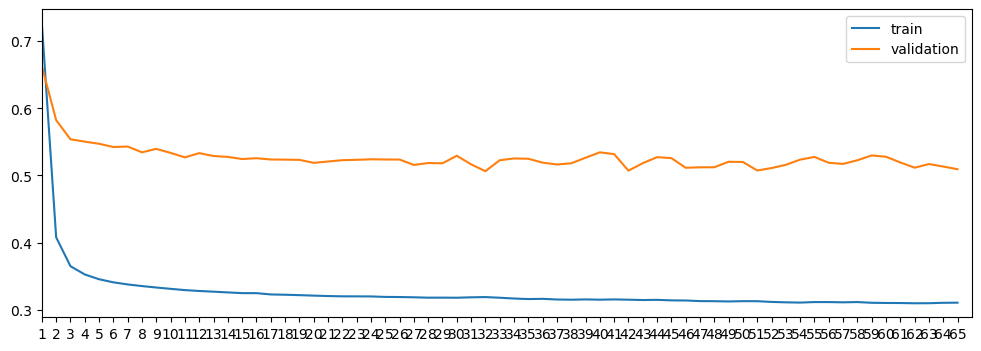

Epoch:65 Training Loss:0.3103890288260675 Validation Loss:0.509324172941598: 100%|██████████| 65/65 [1:43:13<00:00, 95.29s/it] 


In [36]:
epochs = 65
optim = Adam(model.parameters(), lr=0.00002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNFill256FLAIR.pt")

In [37]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNFill256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.22209602917029866
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.3966, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [38]:
transform, transform_label=transform_normalization(256,True,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


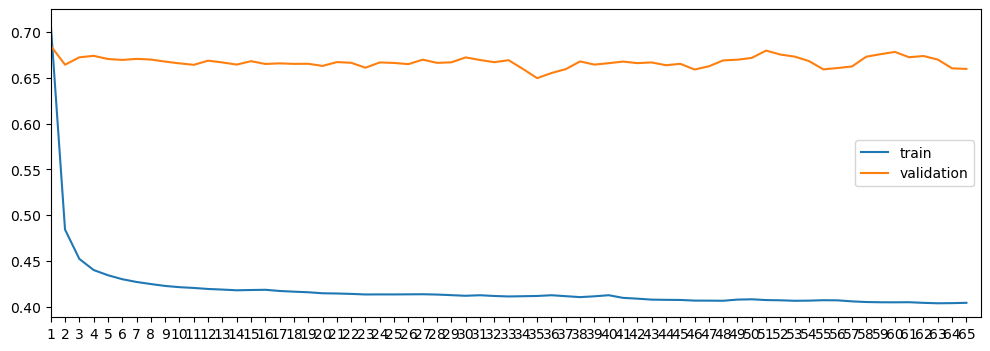

Epoch:65 Training Loss:0.4043501788570035 Validation Loss:0.6597213724539239: 100%|██████████| 65/65 [1:43:33<00:00, 95.59s/it]


In [39]:
epochs = 65
optim = Adam(model.parameters(), lr=0.00002)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNFill256T1.pt")

In [40]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_RESIZE/GNFill256T1.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:127: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


Dice coefficient: 0.11995184526068012
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


## MINMAX NORMALIZATION RESIZE 256X256

- 2: min max normalization
- 4: min max del cerebro
- 6: minmax del cerebro entero

In [23]:
transform, transform_label=transform_normalization(256,True,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


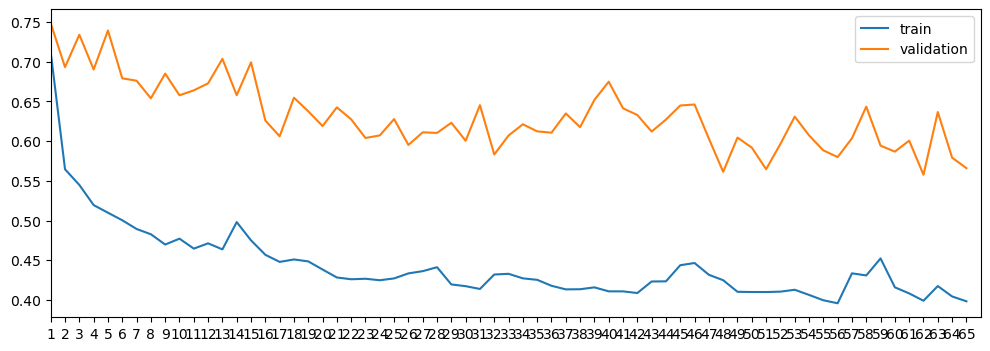

Epoch:65 Training Loss:0.3981597081307442 Validation Loss:0.5659934205133423: 100%|██████████| 65/65 [1:31:41<00:00, 84.64s/it] 


In [24]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MM256FLAIR.pt")

In [25]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MM256FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.20378756729187444
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.3933, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [26]:
transform, transform_label=transform_normalization(256,True,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


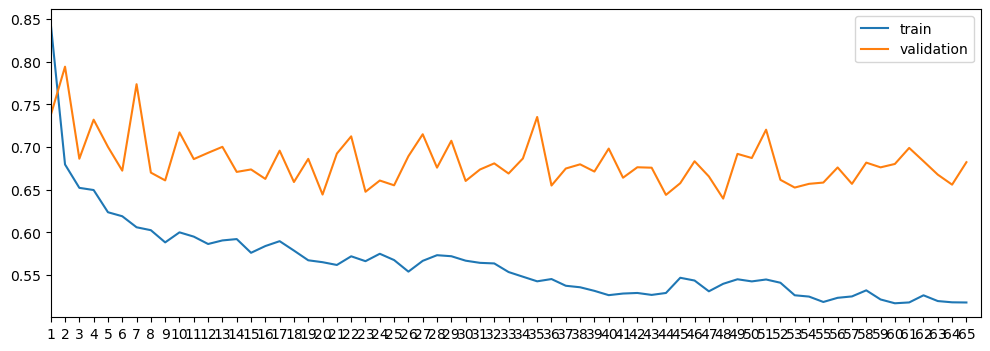

Epoch:65 Training Loss:0.5180127297678302 Validation Loss:0.6822154394175631: 100%|██████████| 65/65 [1:33:06<00:00, 85.94s/it]


In [27]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MM256T1.pt")

In [28]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MM256T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.1234064128672655
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [29]:
transform, transform_label=transform_normalization(256,True,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


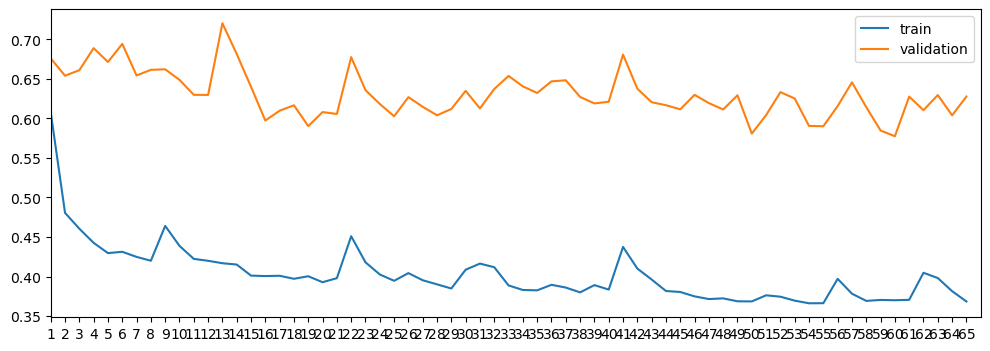

Epoch:65 Training Loss:0.3684891123925486 Validation Loss:0.6276373443359524: 100%|██████████| 65/65 [1:37:48<00:00, 90.28s/it]


In [30]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMmask256FLAIR.pt")

In [31]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MMmask256FLAIR.pt")
calculate_metrics(model,test_dl, device)

RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [ ]:
transform, transform_label=transform_normalization(256,True,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMmask256T1.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MMmask256T1.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(256,True,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMFill256FLAIR.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE//MMFill256FLAIR.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(256,True,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMFill200T1.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_RESIZE/MMFill200T1.pt")
calculate_metrics(model,test_dl, device)

## Gaussian Normalization CropandPad 200x200

In [11]:
model = UNet(in_channels=1,out_channels=1, init_features=32, is200pad=True,is200crop=False)
model= model.to(device)

In [12]:
transform, transform_label=transform_normalization(200,False,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


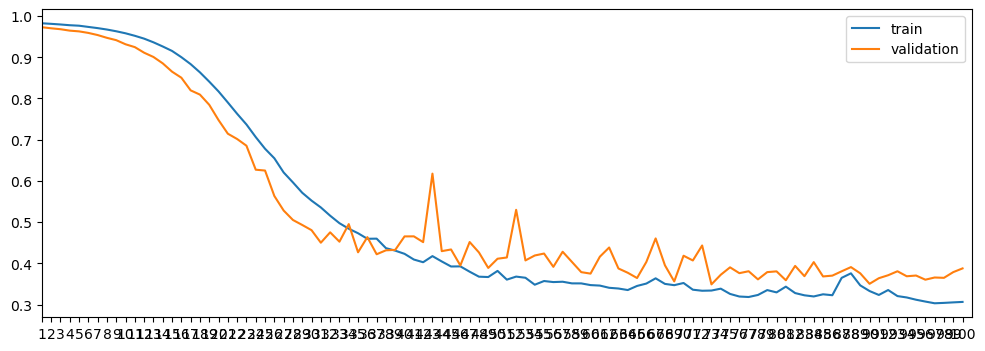

Epoch:100 Training Loss:0.30631727480119275 Validation Loss:0.38765557480148105: 100%|██████████| 100/100 [1:31:22<00:00, 54.82s/it]


In [14]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GN200FLAIR.pt")

In [15]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GN200FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\monai\metrics\utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Dice coefficient: 0.23811681095486212
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.4905, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [16]:
transform, transform_label=transform_normalization(200,False,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


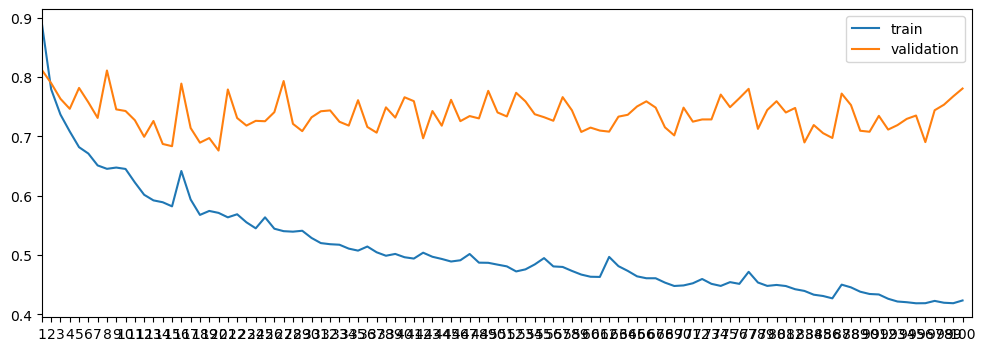

Epoch:100 Training Loss:0.4234753689458293 Validation Loss:0.780424403718605: 100%|██████████| 100/100 [1:32:03<00:00, 55.23s/it]


In [17]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GN200T1.pt")

In [18]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GN200T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.04345455434032422
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [19]:
transform, transform_label=transform_normalization(200,False,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


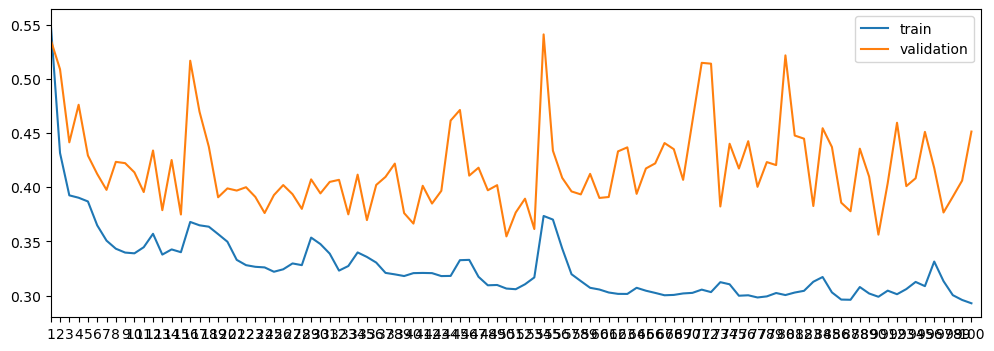

Epoch:100 Training Loss:0.29286297175192066 Validation Loss:0.45126101891554793: 100%|██████████| 100/100 [1:40:19<00:00, 60.19s/it]


In [20]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNMask200FLAIR.pt")

In [21]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GNMask200FLAIR.pt")
calculate_metrics(model,test_dl, device)

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\preprocessing.py:127: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  std=torch.std(image[brain==1])


Dice coefficient: 0.26441100439497905
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.4856, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [22]:
transform, transform_label=transform_normalization(200,False,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


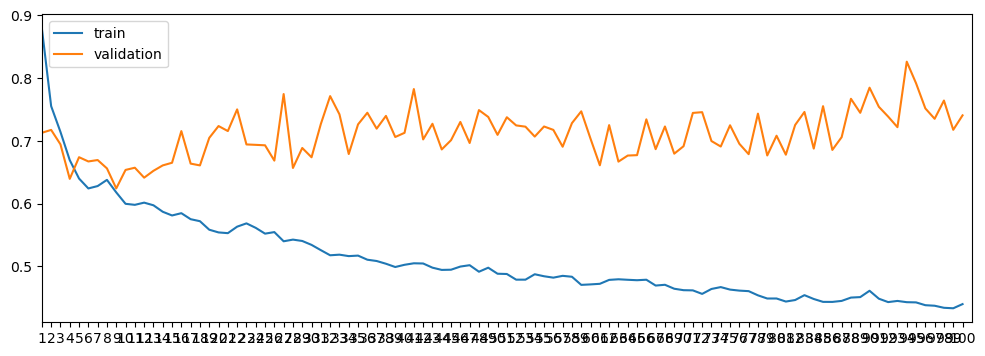

Epoch:100 Training Loss:0.4399926927781874 Validation Loss:0.7404410730862089: 100%|██████████| 100/100 [1:40:50<00:00, 60.51s/it]


In [23]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNMask200T1.pt")

In [24]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GNMask200T1.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.0688130108066712
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(nan, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [25]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


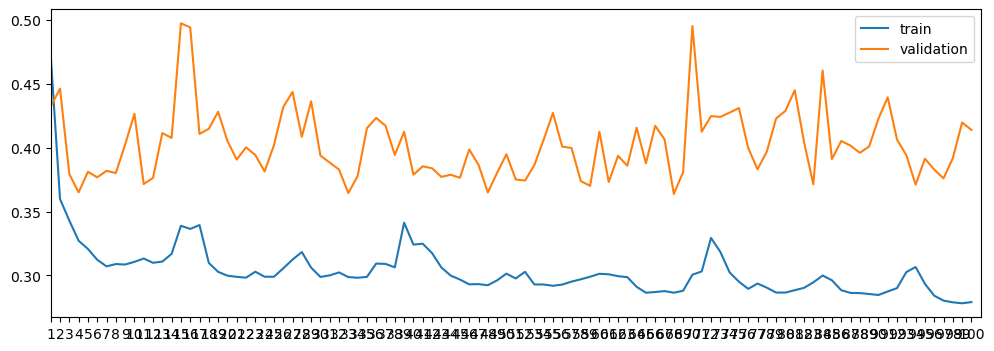

Epoch:100 Training Loss:0.27908094429200697 Validation Loss:0.413992434825192: 100%|██████████| 100/100 [1:48:53<00:00, 65.33s/it]


In [26]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNFill200FLAIR.pt")

In [27]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GNFill200FLAIR.pt")
calculate_metrics(model,test_dl, device)

Dice coefficient: 0.2608159403733321
IOU: tensor(nan, device='cuda:0')
Hausdorff Distance: tensor(inf)
Precision: tensor(nan, device='cuda:0')
Recall: tensor(0.4465, device='cuda:0')
Accuracy: tensor(nan, device='cuda:0')


In [28]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,15,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
514


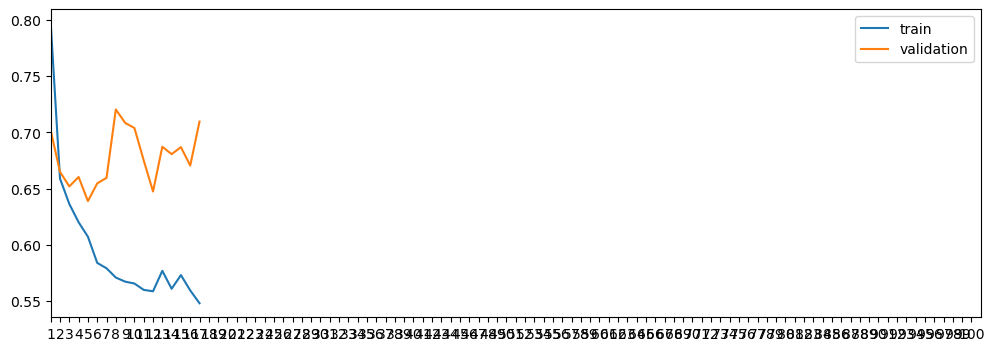

Epoch:17 Training Loss:0.5481614255136059 Validation Loss:0.7097326610183321:  17%|█▋        | 17/100 [18:47<1:32:36, 66.94s/it]

In [29]:
epochs = 100
optim = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNFill200T1.pt")

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/GN_CROP/GNFill200T1.pt")
calculate_metrics(model,test_dl, device)

## Min max Normalization 200x200 crop and pad

In [ ]:
model = UNet(in_channels=1,out_channels=1, init_features=32, is200pad=False,is200crop=True)

In [ ]:
transform, transform_label=transform_normalization(200,False,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2232
593


In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MM200Flair.pt")

  0%|          | 0/65 [00:58<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MM200Flair.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(200,False,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2232
593


In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MM200T1.pt")

  0%|          | 0/65 [00:31<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MM200T1.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(200,False,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2232
593


In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMmask200Flair.pt")

  0%|          | 0/65 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MMmask200Flair.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(200,False,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2232
593


In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMmask200T1.pt")

  0%|          | 0/65 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MMmask200T1.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(200,False,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2232
593


In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMFill200FLAIR.pt")

  0%|          | 0/65 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MMFill200FLAIR.pt")
calculate_metrics(model,test_dl, device)

In [ ]:
transform, transform_label=transform_normalization(200,False,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2232
593


In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMFill200T1.pt")

  0%|          | 0/65 [00:23<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/MM_CROP/MMFill200T1.pt")
calculate_metrics(model,test_dl, device)

# Modelos con skull striping

# Modelos Con Concatenate

Se ha seleccionado inicialmente crop de 240 y normalizacion fill brain gaussian

In [14]:
transform, transform_label=transform_setter(200,False)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsFLAIR","pathsT1",train,val,transform, transform_label,False,10)
test_data=Concatenate(TEST_DICT.get("pathsFLAIR"),TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2311
634


In [15]:
model = UNet(in_channels=2, out_channels=1, init_features=32, is200pad=True,is200crop=False)
model=model.to(device)

In [16]:
epochs = 5
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/pruebaConcatenate.pt")

  0%|          | 0/5 [00:52<?, ?it/s]


TypeError: 'list' object is not callable

In [ ]:
model=assignPretrainedModel(device,"./Modelos3DUNET/pruebaConcatenate.pt")
calculate_metrics(model,test_dl, device)

# Data Augmentation

- Rotation (-15,15)
- Scale (0.9,1.1)
- Shearing(-18,18)


In [ ]:
fig,axs = plt.subplots(1, 4, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')

image_rot=dataAugmentation(image_data[:, :, 53],(-15,15),None,None)
axs[1].imshow(image_rot.squeeze(0), cmap='gray')
axs[1].set_title("Rotation %s" %(image_rot.shape,))
axs[1].axis('off')

image_scale=dataAugmentation(image_data[:, :, 53],(0,0),(0.9,1.1),None)
axs[2].imshow(image_scale.squeeze(0), cmap='gray')
axs[2].set_title("scale %s" %(image_scale.shape,))
axs[2].axis('off')

image_she=dataAugmentation(image_data[:, :, 53],(0,0),None,(-18,18))
axs[3].imshow(image_she.squeeze(0), cmap='gray')
axs[3].set_title("shear %s" %(image_she.shape,))
axs[3].axis('off')